In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def baseline_model(dense_size, input_dim):
    # create model
    model = Sequential()
    model.add(Dense(dense_size, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='sgd')
    model.summary()
    return model

In [3]:
# Chargement et normalisation des données
df = pd.read_pickle('data/data.pkl')
data = df[['h2s', 'pressure', 'temperature', 'humidity', 'so2', 'h2s_ref']]
df[['h2s', 'pressure', 'temperature', 'humidity', 'so2', 'h2s_ref']] =  data.apply(pd.to_numeric, errors="coerce").apply(lambda x: (x - np.mean(x)) / (np.std(x)))
print(len(df))
df = df[pd.notnull(df).all(axis=1)] # On ne garde que les données sans NaN etc..
print(len(df))
df.head()

19445
8676


,date,h2s,pressure,temperature,humidity,n_points,so2,h2s_ref,captor
4,2016-05-23 09:15:00,1.673433,0.047316,0.996046,-1.610853,15,-0.259294,-0.709240,1303
9,2016-05-23 10:30:00,1.530588,0.202130,0.996046,-1.677224,15,-0.259294,-0.709240,1303
20,2016-05-23 13:15:00,1.637722,0.356944,0.996046,-1.809965,15,-0.259294,-0.709240,1303
25,2016-05-23 14:30:00,1.655577,0.356944,0.996046,-1.809965,15,-0.259294,-0.561424,1303
31,2016-05-23 16:00:00,1.566299,0.356944,0.996046,-1.876336,15,-0.259294,-0.709240,1303


In [4]:
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    print(nb_rows, len(dataframe))
    return dataframe[:nb_rows], dataframe[nb_rows:]

df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

4338 8676
2169 4338


In [5]:
def dataframe_to_xy(df):
    return np.array(df[['h2s', 'pressure', 'temperature', 'humidity', 'so2']]), np.array(df['h2s_ref'])

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)

In [6]:
model = baseline_model(1024, 5)
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=3)
history = model.fit(X_train, y_train, batch_size=5, epochs=100, validation_data=(X_train, y_train), callbacks=[early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              6144      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 7,169
Trainable params: 7,169
Non-trainable params: 0
_________________________________________________________________
Train on 4338 samples, validate on 4338 samples
Epoch 1/100
4338/4338 [==============================] - 2s - loss: 0.2562 - val_loss: 0.5755
Epoch 2/100
4338/4338 [==============================] - 1s - loss: 0.1945 - val_loss: 0.1840
Epoch 3/100
4338/4338 [==============================] - 1s - loss: 0.1782 - val_loss: 0.1658
Epoch 4/100
4338/4338 [==============================] - 1s - loss: 0.1684 - val_loss: 0.1624
Epoch 5/100
4338/4338 [==============================] - 1s - loss: 0.1682 - val_loss: 0.1621
Epoch 6/100
4338/4

In [7]:
model.evaluate(X_train, y_train, batch_size=1)

4324/4338 [============================>.] - ETA: 0s

0.082430476351377041

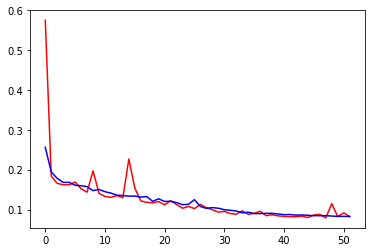

In [8]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

plt.figure()
plt.plot(history.history['val_loss'], 'r')
plt.plot(history.history['loss'], 'b')
plt.show()

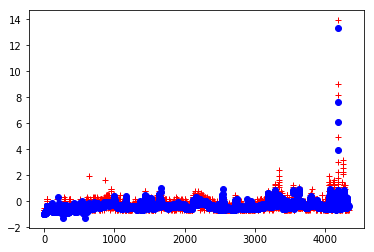

In [9]:
y_pred = model.predict(X_train)
plt.figure()
plt.plot(y_train, 'r+')
plt.plot(y_pred, 'bo')
plt.show()

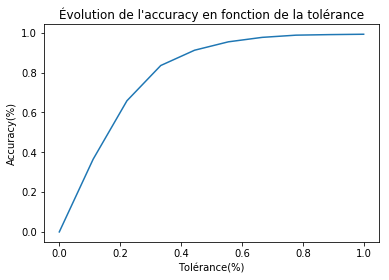

In [12]:
tolerances = np.linspace(0, 1, 10)
acc = []
for tol in tolerances:
    y_tol = tol*y_test.flatten()
    accur = np.sum(np.abs(y_pred.flatten() - y_train.flatten()) <= tol) / len(y_train)
    acc.append(accur)

plt.plot(tolerances, acc)
plt.title("Évolution de l'accuracy en fonction de la tolérance")
plt.xlabel("Tolérance(%)")
plt.ylabel("Accuracy(%)")
plt.show()

In [ ]:
acc